#Predicting Bitcoin Price

##Data Analysis

Use the exported data from 'Data Collection and Exploration' notebook to create a model for predicting the next day market price of bitcoin.

###Imports

In [104]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import random
from sklearn.linear_model import LinearRegression
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

###Data Munging

Create the outcome variable `next_day`.

In [101]:
data = pd.read_csv('bitcoin_price.csv', index_col='trading_day')

next_day = data['price_usd'].iloc[1:]
data = data.iloc[:-1,:]
data['next_day'] = next_day.values
print data.head()

            Unnamed: 0  block_size  block_transactions  blockchain_size  \
date                                                                      
2009-01-03           0    0.000272                   1                0   
2009-01-04           1    0.000000                   1                0   
2009-01-05           2    0.000000                   1                0   
2009-01-06           3    0.000000                   1                0   
2009-01-07           4    0.000000                   1                0   

            transaction_cost  percent_cost  difficulty  transaction_vol  \
date                                                                      
2009-01-03                 0             0           1                0   
2009-01-04                 0             0           0                0   
2009-01-05                 0             0           0                0   
2009-01-06                 0             0           0                0   
2009-01-07              

Create features for moving averages for price_usd.

In [102]:
data['ma_price_3'] = pd.rolling_mean(data['price_usd'], 3)
data['ma_price_7'] = pd.rolling_mean(data['price_usd'], 7)

data.dropna()
print data.shape

(2559, 34)


Read in the Google Trends result and merge with the main data set.

In [103]:
def merge_columns(main, other):
    result = pd.merge(left=main,right=other, how='outer', left_on='date', right_on='date')
    
    return result


trends = pd.read_csv('bitcoin_trends.csv')
data = merge_columns(data, trends)

KeyError: 'date'

Select data subset of interest. Early timepoints with very low or sparse data are excluded from analysis.

In [59]:
data = data[(data.date >= '2011-01-01') & (data.date <= '2015-12-31')]

In [42]:
print data.corr().head()

                    Unnamed: 0  block_size  block_transactions  \
Unnamed: 0            1.000000    0.894224            0.903477   
block_size            0.894224    1.000000            0.944901   
block_transactions    0.903477    0.944901            1.000000   
blockchain_size       0.894978    0.957238            0.948378   
transaction_cost      0.412324    0.199917            0.212767   

                    blockchain_size  transaction_cost  percent_cost  \
Unnamed: 0                 0.894978          0.412324     -0.048682   
block_size                 0.957238          0.199917     -0.026176   
block_transactions         0.948378          0.212767     -0.027934   
blockchain_size            1.000000          0.242522     -0.023004   
transaction_cost           0.242522          1.000000     -0.023357   

                    difficulty  transaction_vol  hash_rate  market_cap  \
Unnamed: 0            0.769907         0.151497   0.764652    0.711529   
block_size            0.9029

###Correlations

High correlations (>0.8) were identified between the ff. independent variables: 

- Group 1: block_size, block_transactions, blockchain_size, difficulty, hash_rate, all_transactions, sub10000_transactions, sub10_transactions, sub10_transactions, sub100_transactions, sub1000_transactions, short_transactions, nonpopular_transactions, unique_addresses, and total_transactions

- Group 2: transaction_cost, price_usd, miners_revenue, deficit, and market_cap

Low correlations (<0.4) were identified between the outcome `next_day` and the ff. independent variables:

- transaction_volume, percent_cost, confirmation_time, orphaned_blocks, transaction_fees, output_volume, trade_transaction_ratio,

  

In [43]:
columns_to_include = ['price_usd', 'exchange_vol_usd', 'blockchain_size',  
                      'total_bitcoins', 'total_transactions', 'bitcoin', 'ma_price_7', 
                      'ma_price_3', 'transaction_fees_usd', 'next_day']
selected_columns = list(set(columns_to_include) - set(['Unnamed: 0']))

df = data[selected_columns]
print df.tail()

      total_transactions  next_day  price_usd  exchange_vol_usd  \
2549           100778333    428.00     431.13     3991988.23458   
2550            31110333    793.00     830.90     6073510.13809   
2551           100960169    429.34     428.00     4412445.45045   
2552            31168730    801.53     793.00    11288488.38490   
2553           101124301    432.33     429.34     2829033.49276   

      blockchain_size  bitcoin  ma_price_7  transaction_fees_usd  ma_price_3  \
2549            50929       65  434.555714          13828.106440  424.523333   
2550            13236       65  839.641429          11074.463980  833.116667   
2551            51022       65  432.641429          13565.082115  427.703333   
2552            13264       65  834.718571          11846.102835  823.866667   
2553            51101       65  429.125714          11653.804046  429.490000   

      total_bitcoins  
2549        15020675  
2550        12271450  
2551        15025000  
2552        12275275  
2

### Ordinary Least-Squares Regression Model

In [44]:
lm = smf.ols('next_day ~ exchange_vol_usd + blockchain_size + total_bitcoins + total_transactions  + bitcoin + ma_price_7 + ma_price_3  +  price_usd + transaction_fees_usd', data=df)
fit = lm.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:               next_day   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 5.830e+04
Date:                Sun, 10 Jan 2016   Prob (F-statistic):               0.00
Time:                        20:23:47   Log-Likelihood:                -8884.4
No. Observations:                2174   AIC:                         1.779e+04
Df Residuals:                    2164   BIC:                         1.785e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.7692 

Next step is to look at the P-values of each feature to determine suitability for inclusion in further analysis. The variables exchange_vol_usd, transaction_fees_usd and ma_price_7 have high P values and may be removed to simplify the model.

In [45]:
lm2 = smf.ols('next_day ~ blockchain_size + total_bitcoins + total_transactions  + bitcoin +  ma_price_3  +  price_usd', data=df)
fit = lm2.fit()

Use statsmodels to plot the residuals.

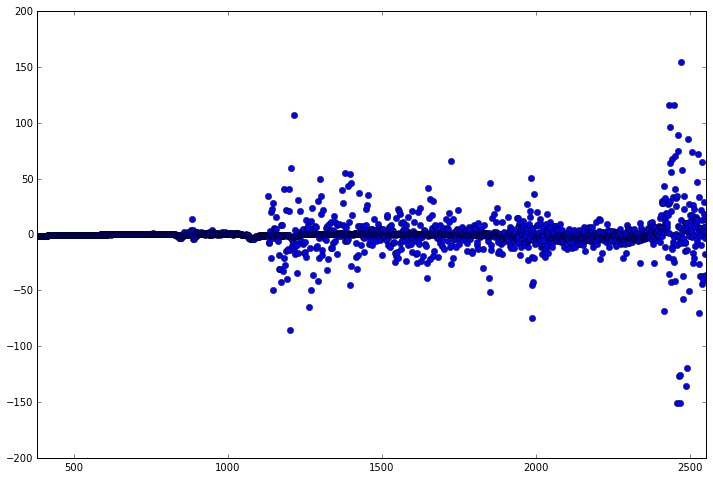

In [46]:
fit.resid.plot(style='o', figsize=(12,8))

###Linear Regression Analysis

Split the data into training and test set.

In [90]:
np.random.seed(1)
random.seed(1)
data = data.loc[np.random.permutation(data.index)]

# Select 70% of the dataset to be training data
highest_train_row = int(data.shape[0] * .7)
train = data.loc[:highest_train_row,:]

# Select 30% of the dataset to be test data.
test = data.loc[highest_train_row:,:]
print test.head()

      Unnamed: 0        date  block_size  block_transactions  blockchain_size  \
1776        1776  2015-10-28    0.194164                 602            11308   
2311        2311  2015-05-03    0.334149                 732            32919   
1033        1033  2013-10-15    0.014442                  40              481   
1797        1797  2015-11-18    0.235772                 337            12046   
1754        1754  2015-10-06    0.127253                 271            10749   

      transaction_cost  percent_cost    difficulty  transaction_vol  \
1776         25.212569      1.522987  5.109297e+08           278926   
2311          9.677762      2.389398  4.761056e+10           144890   
1033          4.518664      5.460776  1.203462e+06           138314   
1797         51.976571      1.670109  7.074083e+08           257229   
1754         19.459328      2.192465  2.677312e+08           242239   

         hash_rate     ...       transaction_fees      output_vol  \
1776  4.292339e+0

Define the method to generate a regression model.

In [83]:
def regression_model(predictor):
    regressor= LinearRegression()

    regressor.fit(train[predictor], train['next_day'])
    predictions = regressor.predict(test[predictor])
    mse = sum((predictions - test['next_day']) ** 2) / len(predictions)
    score = regressor.score(test[predictor], test['next_day'])
    
    return regressor, predictions, mse, score

Define the method to visualize the model statistics. Make scatterplots with the actual values in the training set and test set.

In [92]:
def draw_scatterplot(predictor, regressor, predictions):
    
    #plt.scatter(train[predictor], train['next_day'])
    #plt.plot(train[predictor], regressor.predict(train[predictor]))
    #plt.show()
    plt.scatter(test[predictor], test['next_day'])
    plt.plot(test[predictor], predictions)
    plt.show()


Try out different models parameters.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


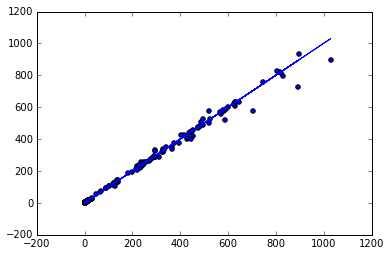

MSE:  354.61908211
Score:  0.992814255981
MSE:  363.483408741
Score:  0.992634635692
MSE:  363.120639156
Score:  0.992641986592


In [93]:
rm , predictions, mse, score = regression_model(['price_usd'])
draw_scatterplot('price_usd', rm, predictions)
print 'MSE: ', mse # 177.90 
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'ma_price_3'])
print 'MSE: ', mse # 178.29
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'ma_price_3', 'ma_price_7'])
print 'MSE: ', mse # 178.12
print 'Score: ', score

MSE:  354.632566719
Score:  0.992813982739


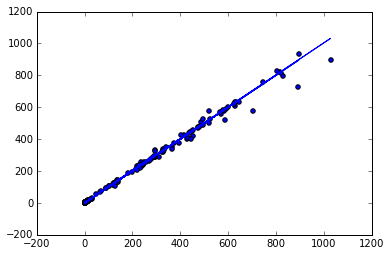

MSE:  356.98785603
Score:  0.992766256863
MSE:  357.754586367
Score:  0.992750720396


In [94]:
rm, predictions, mse, score = regression_model(['price_usd', 'total_transactions'])
print 'MSE: ', mse # 179.42
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'transaction_fees_usd'])
draw_scatterplot('price_usd', rm, predictions)
print 'MSE: ', mse # 177.19
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'transaction_fees_usd', 'total_bitcoins'])
print 'MSE: ', mse
print 'Score: ', score